<a href="https://colab.research.google.com/github/MaryDongsn/NLP_Learning/blob/master/Dialogflow_Intent_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to this Tutorial
The code that follows will walk you through several things:


1.   How to get programmatically use the the Dialogflow API and to interact with your agent programmatically
2.   How to use Tensorflow Hub to get start with Tensorflow Modules and how to use it to generate Embeddings for your training phrases
3.   Once the embeddings are created, how can we use them to detect problems in our Dialogflow agent.

Before starting, we need to install few dependencies

In [2]:
!sudo pip install --quiet --upgrade tensorflow dialogflow scipy tensorflow-hub

In [3]:
import dialogflow_v2 as dialogflow
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from collections import defaultdict
import os
from google.colab import auth
import pickle
print(tf.__version__)

2.2.0


Now, let's set the variables we need. These values should match the entried you used when creating a project and a service account

In [4]:
PROJECT_ID="newagent-ujuskx" # Set your GCP Project Id
SERVICE_ACCOUNT_EMAIL="dilogflow-healthcheck@newagent-ujuskx.iam.gserviceaccount.com" # Set your Dialogflow service account email

### Great
Now, we need to authenticate your session so you can create a key for your service account.

Follow the instructions in the output section of the cell below

In [5]:
auth.authenticate_user()
!gcloud config set project {PROJECT_ID}
!gcloud iam service-accounts keys create sa-key.json \
 --iam-account={SERVICE_ACCOUNT_EMAIL} --project={PROJECT_ID}

Updated property [core/project].
created key [261e0f26ab498c9879c4a04ebead20c0a9194a37] of type [json] as [sa-key.json] for [dilogflow-healthcheck@newagent-ujuskx.iam.gserviceaccount.com]


#### Let's take a snapshot of your Dialogflow account

The following code will issue two api calls to read the entities and the intents of your Dialogflow agent. We'll need these to perform our analysis

In [6]:
def fetch_intents_training_phrases(service_account_file, project):

  dialogflow_entity_client = dialogflow.EntityTypesClient.from_service_account_file(service_account_file)
  parent = dialogflow_entity_client.project_agent_path(project)
  entities = list(dialogflow_entity_client.list_entity_types(parent))

  dialogflow_intents_client = dialogflow.IntentsClient.from_service_account_file(service_account_file)
  parent = dialogflow_intents_client.project_agent_path(project)
  intents = list(dialogflow_intents_client.list_intents(
    parent=parent,
    intent_view=dialogflow.enums.IntentView.INTENT_VIEW_FULL))

  entities_name_to_value = {}
  for intent in intents:
      entities_used = {entity.display_name 
        for entity in intent.parameters}

      for entity in entities:
          if entity.display_name in entities_used \
                  and entity.display_name not in entities_name_to_value:
                  
              entities_name_to_value[entity.display_name] = np.random.choice(
                  np.random.choice(entity.entities).synonyms, replace=False)

  intent_training_phrases = defaultdict(list)
  for intent in intents:
      for training_phrase in intent.training_phrases:

          parts = [
              entities_name_to_value[part.alias] 
              if part.alias in  entities_name_to_value else part.text
              for part in training_phrase.parts
          ]
          intent_training_phrases[intent.display_name].append(
              "".join(parts))
      # Remove intents with no training phrases
      if not intent_training_phrases[intent.display_name]:
          del intent_training_phrases[intent.display_name]
  return intent_training_phrases


In [7]:
intent_training_phrases = fetch_intents_training_phrases("sa-key.json", PROJECT_ID)

for intent in intent_training_phrases:
  print("{}:{}".format(intent, intent_training_phrases[intent]))
  print("{}:{}".format(intent, len(intent_training_phrases[intent])))

Asian:['I want to watch an asian movie', 'maybe an asian movie?', 'asian movie seems nice', 'any asian movie?', 'tell me an Asian Movie']
Asian:5
Comedy:['I want to watch some Comedy movie', 'I only watch Comedy movies', 'please recommend a Comedy movie', 'let see what available for a Comedy movie', 'I need to watch a Comedy movie', 'share some Comedy movies suggestion', 'I want to laugh! any Comedy movies?']
Comedy:7
Default Welcome Intent:['just going to say hi', 'heya', 'hello hi', 'howdy', 'hey there', 'hi there', 'greetings', 'hey', 'long time no see', 'hello', "lovely day isn't it", 'I greet you', 'hello again', 'hi', 'hello there', 'a good day']
Default Welcome Intent:16
Documentary:['any suggestions for documentry?', 'list some documentry movies', 'any suggestions for a documentry?', 'I want to watch a documentry about animals.', 'any recommendation for a documentry movie?', 'do you know any documentry?']
Documentary:6
Action:['is there an Action movie your recommend', 'Action 

### Let's create some embeddings

Embeddings are a projection of your data on a space with fewer dimensions
compared to the original space.

It is a lossy transformation and, in this case, we transform the training phrases into points in a space with 512 dimensions.

To do so, we'll use a Tensorflow hub module. [The universal sentence encoder](https://tfhub.dev/google/universal-sentence-encoder/2).

Before working on our data, let's see how it works.

Please note that for each new session the following code block can take a while to complete.
This is because for every session, Google Cloud provisions a new virtual machine, and we need to download the Tensorflow hub module. 


In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
embed_module = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")
tf.initializers.tables_initializer()

Instructions for updating:
non-resource variables are not supported in the long term


<tf.Operation 'init_all_tables' type=NoOp>

Now that we have the module and the Tensorflow operation defined, we can construct the first embeddings.

Before deep-diving in our Dialogflow's training phrases, let's analyze a small and simple synthetic example

In [9]:


def make_embeddings_fn():
    placeholder = tf.placeholder(dtype=tf.string)
    embed = embed_module(placeholder)
    session = tf.Session()
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    def _embeddings_fn(sentences):
        computed_embeddings = session.run(
            embed, feed_dict={placeholder: sentences})
        return computed_embeddings
    return _embeddings_fn

generate_embeddings = make_embeddings_fn()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [16]:
sentences = [
  "I want to watch a movie that released before 2000",
  "do you know any documentaries",
  "Goodbye",
  "Can you tell me a movie produced by Disney"
]
computed_embeddings = generate_embeddings(sentences)

Now you can see how the embeddings look like. Specifically, they are projections of the original sentences in a `512` dimensional space. This high-dimensional space is impossible to visualize for a human. So, let's project them to a 3-d space that we can visualize and comprehend.

To achieve this, we use Principal Component Analysis (PCA). PCA is a lossy transformation that conserves most of the variance in the data. This let's us plot the points in a 3d space while conserving the best we can the distance between the sentences.

Let's also print the relative distances between every point-pair.

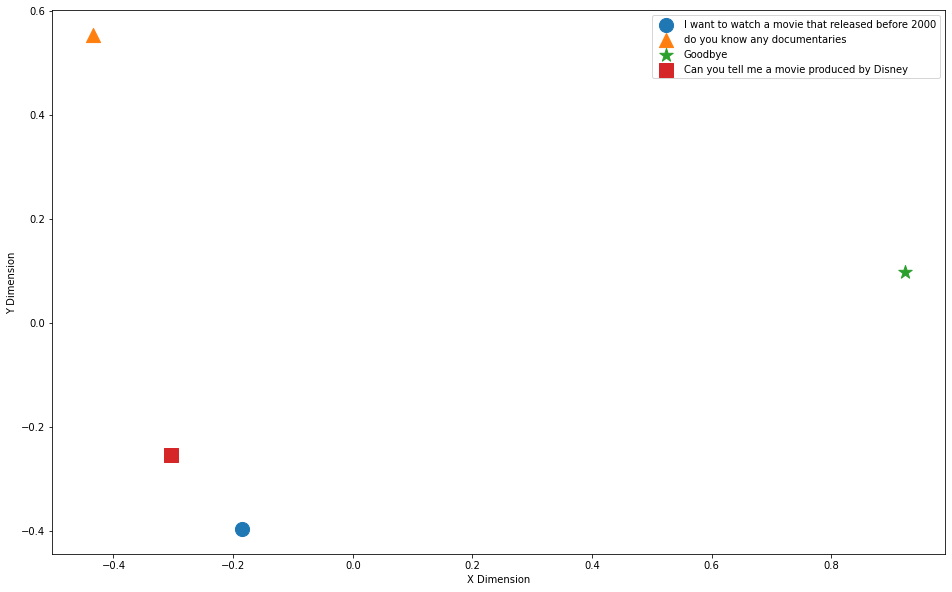

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math

point_size=200

pca = PCA(n_components=2)
points_2d = pca.fit_transform(computed_embeddings)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)

for point, marker in zip(points_2d, ['o', '^', '*', 's']):
  xs = point[0]
  ys = point[1]
  ax.scatter(xs, ys, marker=marker, s=point_size)

ax.set_xlabel('X Dimension')
ax.set_ylabel('Y Dimension')

ax.legend(sentences)
plt.show()

As you can see, our method seems to work. 'Hi' and 'Hello' are similar sentences, and hence they remain closer than any other pair of sentences in our simple example.

Let's now use this method to analyze our dialogflow training phrases

In [18]:
training_phrases_with_embeddings = defaultdict(list)
for intent_name, training_phrases_list in intent_training_phrases.items():
  computed_embeddings = generate_embeddings(training_phrases_list)
  training_phrases_with_embeddings[intent_name] = dict(zip(training_phrases_list, computed_embeddings))

In [19]:
for intent_name, _ in training_phrases_with_embeddings.items():
  training_phrase, embeddings = next(iter(training_phrases_with_embeddings[intent_name].items()))
  print("{}: {{'{}':{}}}".format(intent_name, training_phrase, embeddings[:5]))

Asian: {'I want to watch an asian movie':[-0.03200689 -0.07466505  0.00922933 -0.03052555  0.05638206]}
Comedy: {'I want to watch some Comedy movie':[ 0.00832635 -0.02156101 -0.03157195  0.02532358 -0.02657226]}
Default Welcome Intent: {'just going to say hi':[ 0.06459191 -0.01705992 -0.02147556  0.02477609 -0.0295305 ]}
Documentary: {'any suggestions for documentry?':[ 0.01381703  0.00205131 -0.03902698  0.06102355 -0.08027479]}
Action: {'is there an Action movie your recommend':[-0.01184875 -0.03784366 -0.04149282 -0.04126916  0.01030052]}
Old: {'Old movies please!':[-0.04147471 -0.04542603 -0.01737741 -0.01415931 -0.05567201]}
Disney: {'Disney movies please!':[-0.03353189  0.00526064 -0.03329213  0.04361625  0.00499587]}
Oscar: {'how about an oscar movie':[ 0.04455394 -0.04666462 -0.03445528 -0.07068237 -0.0590299 ]}
Length: {'I think a movie that is longer than 2 hours is a good idea':[-0.01607551  0.01261094 -0.02978587 -0.07815537  0.02197171]}


### Let's see how our training phrases are doing!


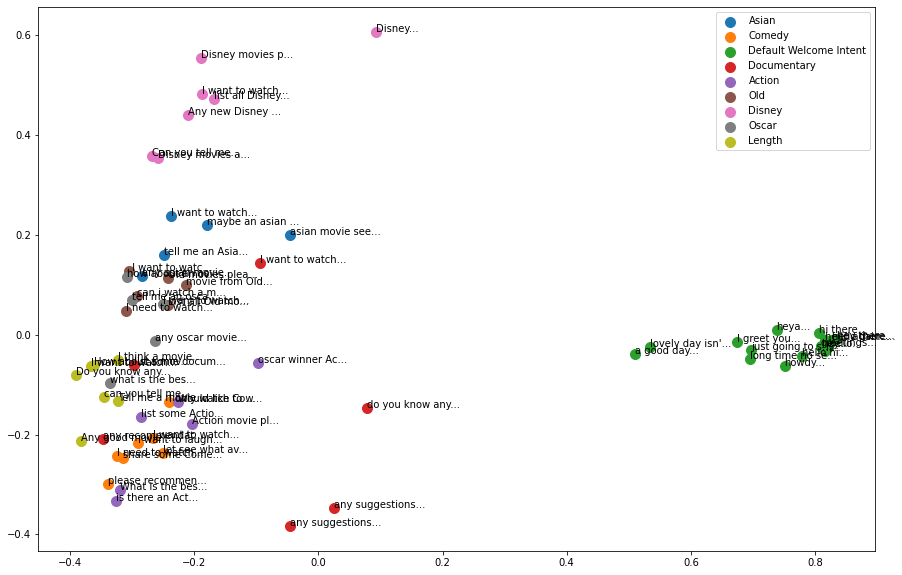

In [20]:
from sklearn.decomposition import PCA

embedding_vectors = []

for intent, training_phrases_and_embeddings in training_phrases_with_embeddings.items():
  for training_phrase, embeddings in training_phrases_and_embeddings.items():
    embedding_vectors.append(embeddings)

embedding_vectors = np.asarray(embedding_vectors)

pca = PCA(n_components=2)
pca.fit(embedding_vectors)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

legend = []

for color, intent in enumerate(training_phrases_with_embeddings.keys()):
  phrases = list(training_phrases_with_embeddings[intent].keys())
  embeddings = list(training_phrases_with_embeddings[intent].values())
  points = pca.transform(embeddings)
  xs = points[:,0]
  ys = points[:,1]
  ax.scatter(xs, ys, marker='o', s=100, c="C"+str(color))
  for i, phrase in enumerate(phrases):
    ax.annotate(phrase[:15] + '...', (xs[i], ys[i]))
  legend.append(intent)


ax.legend(legend)
plt.show()

### Cosine similarity
[Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is a similarity metric that scales well high-dimensional spaces. What it does is simple: given two vectors of numbers it calculates the cosine of angle between them.


![formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/1d94e5903f7936d3c131e040ef2c51b473dd071d)

![](http://blog.christianperone.com/wp-content/uploads/2013/09/cosinesimilarityfq1.png)

To calculate this we can use `sklearn.metrics` package without coding it ourselves.


Before computing every possible pair of sentences, let's measure how *disperse* are our intents.

In [21]:
from sklearn.metrics.pairwise import cosine_similarity      

flatten = []

for intent in training_phrases_with_embeddings:
  for phrase in training_phrases_with_embeddings[intent]:
    flatten.append((intent, phrase,  training_phrases_with_embeddings[intent][phrase]))

data = []
for i in range(len(flatten)):
  for j in range(i+1, len(flatten)):

    intent_1 = flatten[i][0]
    phrase_1 = flatten[i][1]
    embedd_1 = flatten[i][2]

    intent_2 = flatten[j][0]
    phrase_2 = flatten[j][1]
    embedd_2 = flatten[j][2]

    similarity = cosine_similarity([embedd_1], [embedd_2])[0][0]

    record = [intent_1, phrase_1, intent_2, phrase_2, similarity]
    data.append(record)

similarity_df = pd.DataFrame(data, 
  columns=["Intent A", "Phrase A", "Intent B", "Phrase B", "Similarity"])

In [22]:
different_intent = similarity_df['Intent A'] != similarity_df['Intent B']
display(similarity_df[different_intent].sort_values('Similarity', ascending=False).head(5))

,Intent A,Phrase A,Intent B,Phrase B,Similarity
1457,Documentary,list some documentry movies,Action,list some Action movies,0.904298
1461,Documentary,list some documentry movies,Old,List all Old movies,0.868929
451,Comedy,please recommend a Comedy movie,Documentary,any recommendation for a documentry movie?,0.815093
1553,Documentary,any recommendation for a documentry movie?,Action,is there an Action movie your recommend,0.804996
479,Comedy,please recommend a Comedy movie,Length,Any good movie that is longer than 2 hours?,0.800272


### Compute Intents Cohesion

In [23]:
same_intent = similarity_df['Intent A'] == similarity_df['Intent B']
cohesion_df = pd.DataFrame(similarity_df[different_intent].groupby('Intent A', as_index=False)['Similarity'].mean())
cohesion_df.columns = ['Intent', 'Cohesion']
display(cohesion_df)

,Intent,Cohesion
0,Action,0.526238
1,Asian,0.412953
2,Comedy,0.445761
3,Default Welcome Intent,0.150618
4,Disney,0.493124
5,Documentary,0.422270
6,Old,0.600369
7,Oscar,0.574076


In [24]:
different_intent = similarity_df['Intent A'] != similarity_df['Intent B']
separation_df = pd.DataFrame(similarity_df[different_intent].groupby(['Intent A', 'Intent B'], as_index=False)['Similarity'].mean())
separation_df['Separation'] = 1 - separation_df['Similarity']
del separation_df['Similarity']
display(separation_df.sort_values('Separation'))

,Intent A,Intent B,Separation
33,Old,Length,0.370870
17,Comedy,Old,0.376818
18,Comedy,Oscar,0.382697
16,Comedy,Length,0.392244
3,Action,Oscar,0.392296
34,Old,Oscar,0.409663
12,Comedy,Action,0.410891
32,Old,Disney,0.421227
35,Oscar,Length,0.425924
1,Action,Length,0.440929


## License

Authors:  Marcello Stiner & Khalid Salama

---
**Disclaimer**: This is not an official Google product. The sample code provided for an educational purpose.

---

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---
